In [18]:
# ==============================================
# Modelo Híbrido 1 - Decision-Level Fusion
# Ensemble por soma de probabilidades
# ==============================================

In [19]:
#!pip install ultralytics opencv-python pillow

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# ---------- Bibliotecas ----------

import os
import cv2
import torch
import time
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import product
import timm
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit

In [22]:
path = os.getcwd()
print(path)

#os.chdir(path)
#file_log = open(path + "/mensagem_final_classificar_V2.txt", "a")

/content


In [23]:
# === Configurações Gerais ===

NUM_CLASSES = 15
INPUT_SIZE = 224
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATASET_FOLHA = "/content/drive/MyDrive/TCC/Datasets/Imagens Folhas/Especies"
DATASET_CASCA = "/content/drive/MyDrive/TCC/Datasets/Imagens tronco/EspeciesCascas"

PESOS_FOLHA = "/content/drive/MyDrive/TCC/Datasets/main_weights/Folha/mobilenetv4_best_leaf.pt"
PESOS_CASCA = "/content/drive/MyDrive/TCC/Datasets/main_weights/Casca/mobilenetv4_best_bark.pt"

In [24]:
def stratified_split(dataset, test_split=0.1, valid_split=0.2, seed=42):
    labels = [label for *_, label in dataset.samples]

    sss1 = StratifiedShuffleSplit(
        n_splits=1,
        test_size=test_split,
        random_state=seed
    )
    train_valid_idx, test_idx = next(
        sss1.split(np.zeros(len(labels)), labels)
    )

    labels_train_valid = np.array(labels)[train_valid_idx]

    sss2 = StratifiedShuffleSplit(
        n_splits=1,
        test_size=valid_split,
        random_state=seed
    )
    train_idx, valid_idx = next(
        sss2.split(np.zeros(len(labels_train_valid)), labels_train_valid)
    )

    train_idx = np.array(train_valid_idx)[train_idx]
    valid_idx = np.array(train_valid_idx)[valid_idx]

    train_ds = torch.utils.data.Subset(dataset, train_idx)
    valid_ds = torch.utils.data.Subset(dataset, valid_idx)
    test_ds  = torch.utils.data.Subset(dataset, test_idx)

    return train_ds, valid_ds, test_ds

In [25]:
# ================= Dataset Base =================
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {c: i for i, c in enumerate(classes)}

        for cls in classes:
            cls_path = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_path):
                continue
            for f in os.listdir(cls_path):
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((os.path.join(cls_path, f),
                                         self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def preprocess(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (INPUT_SIZE, INPUT_SIZE))
        img = img.astype(np.float32) / 255.0

        mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
        img = (img - mean) / std

        img = np.transpose(img, (2, 0, 1))
        return torch.from_numpy(img)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        # leitura via OpenCV
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # redimensionar
        img = cv2.resize(img, (INPUT_SIZE, INPUT_SIZE))
        # converter para float32 e normalizar [0,1]
        img = img.astype(np.float32) / 255.0
        # talvez normalização adicional conforme modelo (media/std)
        # usando valores padrão ImageNet
        mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
        img = (img - mean) / std
        # mudar de H×W×C para C×H×W
        img = np.transpose(img, (2,0,1))
        img_tensor = torch.from_numpy(img)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return img_tensor, label_tensor

# ================= Dataset Bimodal =================
class CartesianFusionDataset(Dataset):
    def __init__(self, ds_folha, ds_casca):
        self.samples = []

        # Extrair samples considerando Subset
        def get_samples(ds):
            if isinstance(ds, torch.utils.data.Subset):
                # Pegar apenas os índices do subset
                base_samples = ds.dataset.samples
                return [base_samples[i] for i in ds.indices]
            else:
                return ds.samples

        folha_samples = get_samples(ds_folha)
        casca_samples = get_samples(ds_casca)

        # Agrupar por classe
        folhas_por_classe = {}
        cascas_por_classe = {}

        for img, label in folha_samples:
            if label not in folhas_por_classe:
                folhas_por_classe[label] = []
            folhas_por_classe[label].append(img)

        for img, label in casca_samples:
            if label not in cascas_por_classe:
                cascas_por_classe[label] = []
            cascas_por_classe[label].append(img)

        # Produto cartesiano por classe
        for label in folhas_por_classe.keys():
            if label not in cascas_por_classe:
                continue
            for f_img in folhas_por_classe[label]:
                for c_img in cascas_por_classe[label]:
                    self.samples.append((f_img, c_img, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        folha_path, casca_path, label = self.samples[idx]

        # Preprocessar imagens
        img_f = self.preprocess(folha_path)
        img_c = self.preprocess(casca_path)

        return img_f, img_c, torch.tensor(label, dtype=torch.long)

    def preprocess(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (INPUT_SIZE, INPUT_SIZE))
        img = img.astype(np.float32) / 255.0

        mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
        img = (img - mean) / std

        img = np.transpose(img, (2, 0, 1))
        return torch.from_numpy(img)

In [26]:
# ================= Modelo Base =================
def create_model(num_classes=NUM_CLASSES):
    model = timm.create_model(
        'mobilenetv4_conv_small.e1200_r224_in1k',
        pretrained=False
    )
    model.reset_classifier(num_classes=num_classes)
    return model

# ================= Carregar Modelos =================
def load_frozen_model(weight_path):
    model = create_model()
    model.load_state_dict(torch.load(weight_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    return model

In [27]:
# ================= Avaliação =================
@torch.no_grad()
def evaluate_ensemble(model_folha, model_casca, loader):
    all_preds = []
    all_labels = []
    inference_times = []  # ← NOVO

    softmax = nn.Softmax(dim=1)

    for img_f, img_c, labels in tqdm(loader, desc="Inferência Ensemble"):
        img_f = img_f.to(DEVICE)
        img_c = img_c.to(DEVICE)
        labels = labels.to(DEVICE)

        # ← NOVO: Medir tempo
        start_time = time.time()

        out_f = softmax(model_folha(img_f))
        out_c = softmax(model_casca(img_c))

        probs = out_f + out_c
        preds = torch.argmax(probs, dim=1)

        end_time = time.time()
        batch_time = end_time - start_time
        inference_times.append(batch_time / img_f.size(0))  # Tempo por imagem

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds, average="weighted")
    avg_time = np.mean(inference_times) * 1000  # ← NOVO: em milissegundos
    return acc, f1, avg_time,  all_preds, all_labels

In [28]:
# ================= Avaliação Individual =================
@torch.no_grad()
def evaluate_single_older_version(model, loader, modality="folha"):
    """
    Avalia modelo individual (só folhas OU só cascas).

    Args:
        modality: "folha" ou "casca"
    """
    all_preds = []
    all_labels = []
    inference_times = []  # ← NOVO

    for img_f, img_c, labels in tqdm(loader, desc=f"Eval {modality}"):
        # Escolher modalidade
        img = img_f if modality == "folha" else img_c
        img = img.to(DEVICE)
        labels = labels.to(DEVICE)

        # ← NOVO: Medir tempo
        start_time = time.time()

        output = model(img)
        preds = torch.argmax(output, dim=1)

        end_time = time.time()
        batch_time = end_time - start_time
        inference_times.append(batch_time / img.size(0))

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    avg_time = np.mean(inference_times) * 1000  # ← NOVO: em milissegundos
    return acc, f1, avg_time, all_preds, all_labels

In [29]:
# ================= Avaliação Individual CORRETA =================
@torch.no_grad()
def evaluate_single(model, loader):
    """
    Avalia modelo em dataset UNIMODAL (sem pares).
    """
    all_preds = []
    all_labels = []
    inference_times = []

    for batch in tqdm(loader, desc="Inferência"):
        # Loader unimodal retorna (img, label) não (img_f, img_c, label)
        if len(batch) == 2:
            img, labels = batch
        else:
            # Se for bimodal, desempacotar
            img, labels = batch[0], batch[2]

        img = img.to(DEVICE)
        labels = labels.to(DEVICE)

        start_time = time.time()
        output = model(img)
        preds = torch.argmax(output, dim=1)
        end_time = time.time()

        batch_time = end_time - start_time
        inference_times.append(batch_time / img.size(0))

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    avg_time = np.mean(inference_times) * 1000

    return acc, f1, avg_time, all_preds, all_labels

In [40]:
# ================= Funções de Análise =================
def plot_confusion_matrix(y_true, y_pred, class_names, title="Matriz de Confusão", normalize=False):
    """
    Plota matriz de confusão com visualização aprimorada.

    Args:
        y_true: Labels verdadeiros
        y_pred: Predições do modelo
        class_names: Lista com nomes das classes
        title: Título do gráfico
        normalize: Se True, normaliza os valores por linha (%) - (Importante! As outras matrizes dos modelos simples estão como número bruto)
    """
    cm = confusion_matrix(y_true, y_pred)
    #df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2%'
    else:
        fmt = 'd'

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Porcentagem' if normalize else 'Contagem'})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Classe Verdadeira', fontsize=12)
    plt.xlabel('Classe Predita', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def print_per_class_accuracy(y_true, y_pred, class_names):
    """
    Imprime acurácia por classe e outras métricas detalhadas.

    Args:
        y_true: Labels verdadeiros
        y_pred: Predições do modelo
        class_names: Lista com nomes das classes
    """
    cm = confusion_matrix(y_true, y_pred)

    print("\n" + "="*80)
    print("ACURÁCIA POR CLASSE")
    print("="*80)
    print(f"{'Classe':<25} {'Corretas':>10} {'Total':>10} {'Acurácia':>12}")
    print("-"*80)

    per_class_acc = []
    for i, class_name in enumerate(class_names):
        correct = cm[i, i]
        total = cm[i, :].sum()
        acc = correct / total if total > 0 else 0
        per_class_acc.append(acc)
        print(f"{class_name:<25} {correct:>10} {total:>10} {acc:>12.2%}")

    print("-"*80)
    print(f"{'MÉDIA':<25} {'':<10} {'':<10} {np.mean(per_class_acc):>12.2%}")
    print("="*80)

    # Relatório de classificação detalhado
    print("\n" + "="*80)
    print("RELATÓRIO DE CLASSIFICAÇÃO DETALHADO")
    print("="*80)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    return per_class_acc

('all_preds,', 'all_labels')

In [31]:
# ================= Função de Predição para Teste =================

def predict_single_pair(model_folha, model_casca, img_folha_path, img_casca_path, class_names=None):
    """
    Faz predição em um único par de imagens (folha + casca).

    Args:
        model_folha: Modelo treinado para folhas
        model_casca: Modelo treinado para cascas
        img_folha_path: Caminho da imagem de folha
        img_casca_path: Caminho da imagem de casca
        class_names: Lista com nomes das classes (opcional)

    Returns:
        dict com predições e probabilidades de cada modelo
    """
    import time

    # Preprocessar imagens
    def preprocess(img_path):
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Não foi possível ler: {img_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (INPUT_SIZE, INPUT_SIZE))
        img = img.astype(np.float32) / 255.0

        mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
        img = (img - mean) / std

        img = np.transpose(img, (2, 0, 1))
        return torch.from_numpy(img).unsqueeze(0)  # Adiciona dimensão de batch

    # Preprocessar
    img_f = preprocess(img_folha_path).to(DEVICE)
    img_c = preprocess(img_casca_path).to(DEVICE)

    softmax = nn.Softmax(dim=1)

    # Inferência
    with torch.no_grad():
        start_time = time.time()

        # Modelo de folhas
        out_f = model_folha(img_f)
        prob_f = softmax(out_f).cpu().numpy()[0]
        pred_f = np.argmax(prob_f)

        # Modelo de cascas
        out_c = model_casca(img_c)
        prob_c = softmax(out_c).cpu().numpy()[0]
        pred_c = np.argmax(prob_c)

        # Ensemble (soma)
        prob_ensemble = (prob_f + prob_c) / 2.0
        pred_ensemble = np.argmax(prob_ensemble)

        end_time = time.time()
        inference_time = (end_time - start_time) * 1000  # ms

    # Preparar resultado
    result = {
        'folha': {
            'classe_pred': int(pred_f),
            'nome_classe': class_names[pred_f] if class_names else f"Classe_{pred_f}",
            'confianca': float(prob_f[pred_f]),
            'probabilidades': prob_f.tolist()
        },
        'casca': {
            'classe_pred': int(pred_c),
            'nome_classe': class_names[pred_c] if class_names else f"Classe_{pred_c}",
            'confianca': float(prob_c[pred_c]),
            'probabilidades': prob_c.tolist()
        },
        'ensemble': {
            'classe_pred': int(pred_ensemble),
            'nome_classe': class_names[pred_ensemble] if class_names else f"Classe_{pred_ensemble}",
            'confianca': float(prob_ensemble[pred_ensemble]),
            'probabilidades': prob_ensemble.tolist()
        },
        'tempo_inferencia_ms': float(inference_time),
        'concordancia': (pred_f == pred_c == pred_ensemble)
    }

    # Exibir resultado formatado
    print(f"\n{'='*70}")
    print(f"PREDIÇÃO - PAR DE IMAGENS")
    print(f"{'='*70}")
    print(f"Folha: {img_folha_path}")
    print(f"Casca: {img_casca_path}")
    print(f"{'-'*70}")
    print(f"{'Modelo':<15} {'Predição':<25} {'Confiança':>12}")
    print(f"{'-'*70}")
    print(f"{'Folhas':<15} {result['folha']['nome_classe']:<25} {result['folha']['confianca']:>12.2%}")
    print(f"{'Cascas':<15} {result['casca']['nome_classe']:<25} {result['casca']['confianca']:>12.2%}")
    print(f"{'-'*70}")
    print(f"{'ENSEMBLE':<15} {result['ensemble']['nome_classe']:<25} {result['ensemble']['confianca']:>12.2%}")
    print(f"{'='*70}")
    print(f"Tempo de inferência: {result['tempo_inferencia_ms']:.2f} ms")

    if result['concordancia']:
        print(f"✅ Todos os modelos CONCORDAM na predição!")
    else:
        print(f"⚠️  Modelos DISCORDAM:")
        if pred_f != pred_ensemble:
            print(f"   - Folhas prevê: {result['folha']['nome_classe']}")
        if pred_c != pred_ensemble:
            print(f"   - Cascas prevê: {result['casca']['nome_classe']}")
        print(f"   - Ensemble decidiu: {result['ensemble']['nome_classe']}")

    return result


--- Modelo Híbrido 1: Decision-Level Fusion ---

Dataset de Folhas:
Classes detectadas (15): dict_keys(['Abacateiro', 'Araca', 'Brinco de Indio', 'Cajueiro', 'Carvalho', 'Caterete', 'Cerejeira', 'Coite', 'Fruta do conde', 'Grevilha', 'Jambolao', 'Laranja Champanhe', 'Louro Pardo', 'Pau Brasil', 'Peroba Rosa'])
Total de Imagens: 704
Total: 704 | Treino: 506 | Validação: 127 | Teste: 71

Dataset de Cascas:
Classes detectadas (15): dict_keys(['Abacateiro', 'Araca', 'Brinco de Indio', 'Cajueiro', 'Carvalho', 'Caterete', 'Cerejeira', 'Coite', 'Fruta do conde', 'Grevilha', 'Jambolao', 'Laranja Champanhe', 'Louro Pardo', 'Pau Brasil', 'Peroba Rosa'])
Total de Imagens: 489
Total: 489 | Treino: 352 | Validação: 88 | Teste: 49

Total: 12731 | Treino: 11765 | Validação: 738 | Teste: 228

=== DEBUG ===
Train: 15 classes presentes de 15 totais
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Valid: 15 classes presentes de 15 totais
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,

Inferência: 100%|██████████| 44/44 [18:11<00:00, 24.81s/it]


Avaliando modelo de CASCAS...


Inferência: 100%|██████████| 31/31 [12:21<00:00, 23.93s/it]


Avaliando ENSEMBLE...


Inferência Ensemble: 100%|██████████| 1421/1421 [1:14:17<00:00,  3.14s/it]



RESULTADOS FINAIS - TESTE
Modelo                   Accuracy     F1-Score      Tempo (ms)
--------------------------------------------------------------------------------
Folhas                     0.9489       0.9476           14.46
Cascas                     0.9939       0.9939           14.31
--------------------------------------------------------------------------------
ENSEMBLE                   0.9972       0.9972           18.31

✅ Ensemble MELHOROU em 0.0033 (+0.33%)

⏱️  TEMPO DE INFERÊNCIA:
   Folhas:   14.46 ms/imagem
   Cascas:   14.31 ms/imagem
   Ensemble: 18.31 ms/imagem (1.27x mais lento)

ANÁLISE DETALHADA - MODELO DE FOLHAS

ACURÁCIA POR CLASSE
Classe                      Corretas      Total     Acurácia
--------------------------------------------------------------------------------
Abacateiro                        42         42      100.00%
Araca                             83         83      100.00%
Brinco de Indio                   79         79      100.00%
Caj

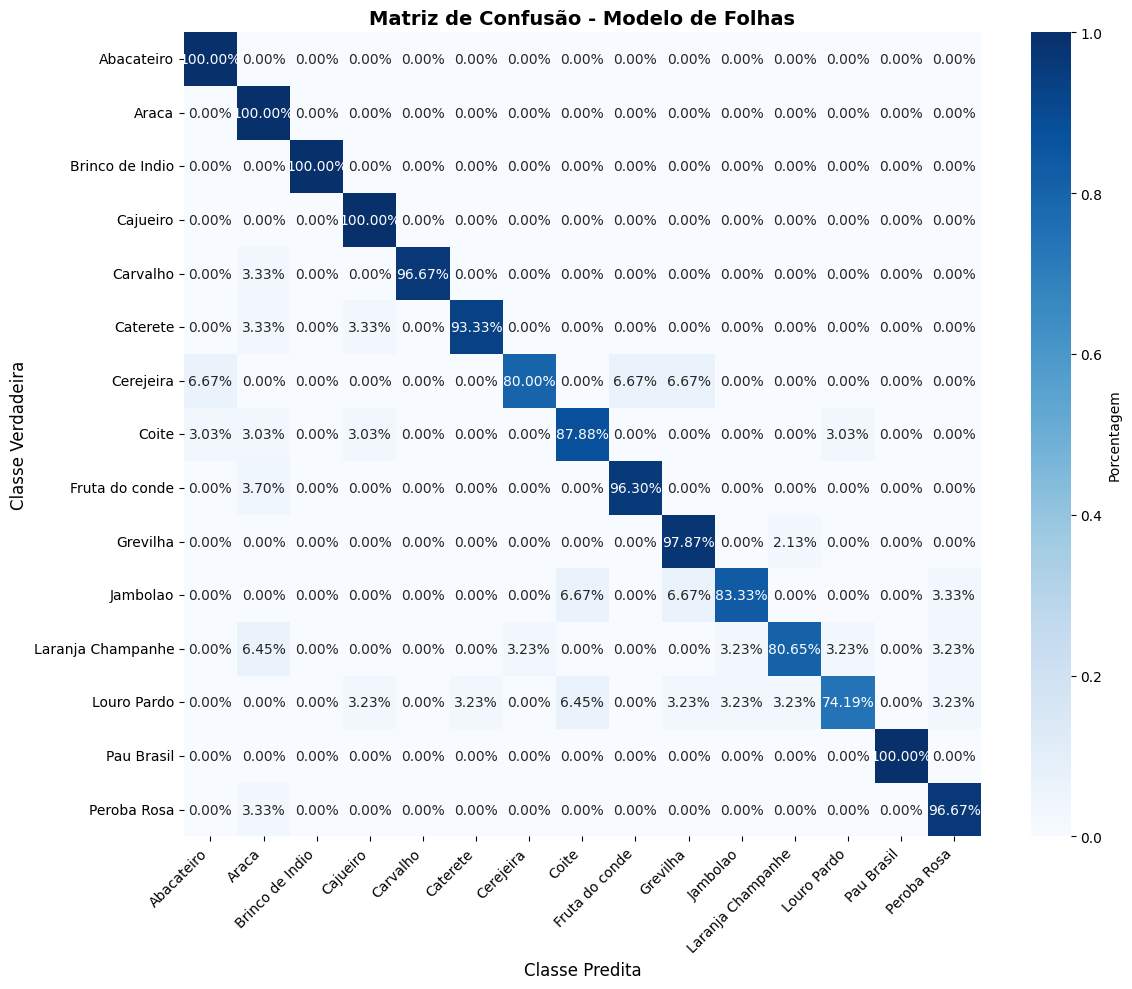


ANÁLISE DETALHADA - MODELO DE CASCAS

ACURÁCIA POR CLASSE
Classe                      Corretas      Total     Acurácia
--------------------------------------------------------------------------------
Abacateiro                        33         34       97.06%
Araca                             32         32      100.00%
Brinco de Indio                   32         32      100.00%
Cajueiro                          32         32      100.00%
Carvalho                          32         32      100.00%
Caterete                          33         34       97.06%
Cerejeira                         33         33      100.00%
Coite                             36         36      100.00%
Fruta do conde                    30         30      100.00%
Grevilha                          34         34      100.00%
Jambolao                          32         32      100.00%
Laranja Champanhe                 33         34       97.06%
Louro Pardo                       30         30      100.00%
Pau Br

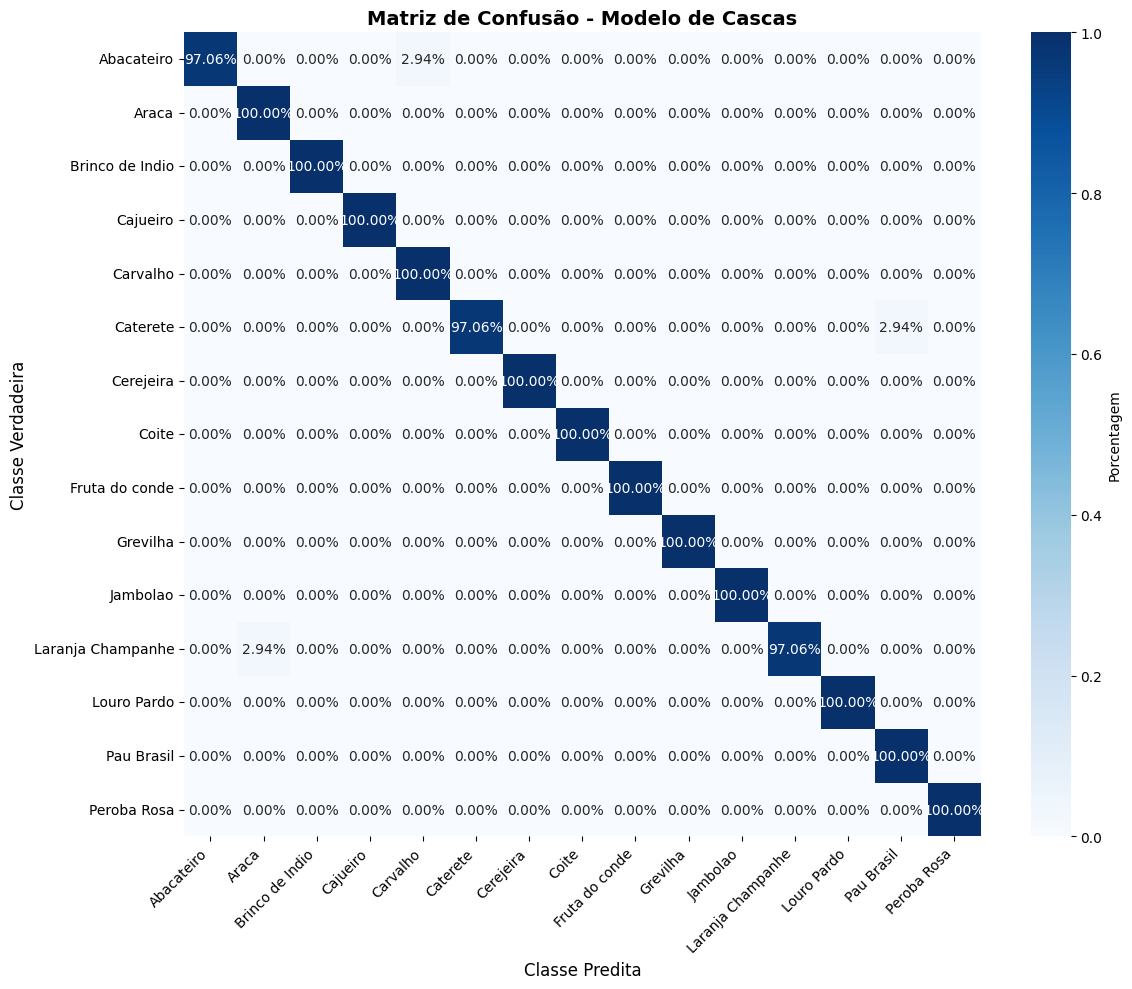


ANÁLISE DETALHADA - ENSEMBLE

ACURÁCIA POR CLASSE
Classe                      Corretas      Total     Acurácia
--------------------------------------------------------------------------------
Abacateiro                      1428       1428      100.00%
Araca                           2656       2656      100.00%
Brinco de Indio                 2528       2528      100.00%
Cajueiro                        2432       2432      100.00%
Carvalho                         960        960      100.00%
Caterete                        1016       1020       99.61%
Cerejeira                        989        990       99.90%
Coite                           1172       1188       98.65%
Fruta do conde                  1619       1620       99.94%
Grevilha                        1598       1598      100.00%
Jambolao                         950        960       98.96%
Laranja Champanhe               1040       1054       98.67%
Louro Pardo                      914        930       98.28%
Pau Brasil    

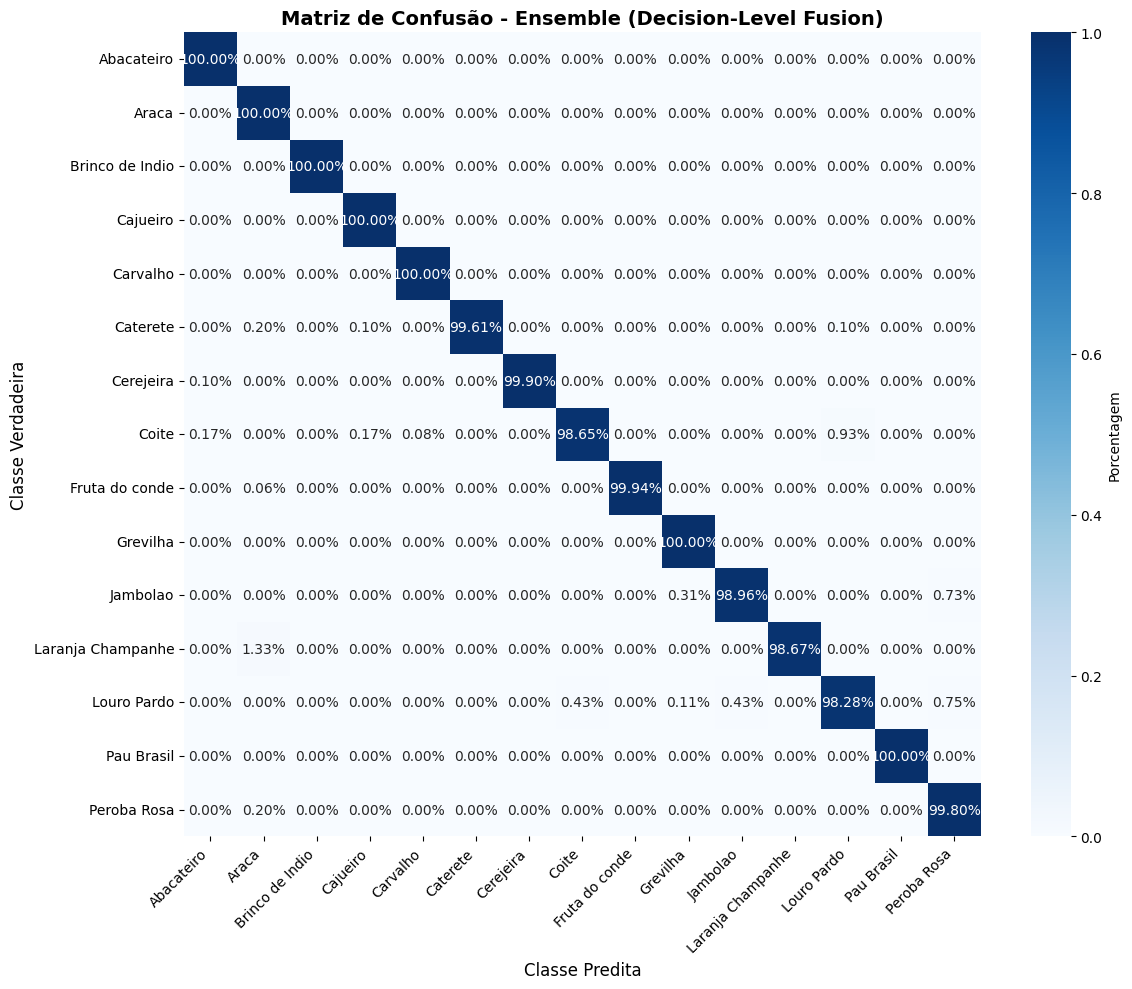

In [43]:
# ================= Main 1 =================

if __name__ == "__main__":
    print("\n--- Modelo Híbrido 1 (MobileNetV4): Decision-Level Fusion ---\n")

    # 1. Dividir datasets originais
    ds_f = ImageFolderDataset(DATASET_FOLHA)
    print(f"Dataset de Folhas:\nClasses detectadas ({len(ds_f.class_to_idx.keys())}): {ds_f.class_to_idx.keys()}")
    print(f"Total de Imagens: {len(ds_f)}")
    train_f, valid_f, test_f = stratified_split(ds_f)
    print(f"Total: {len(train_f)+len(valid_f)+len(test_f)} | Treino: {len(train_f)} | Validação: {len(valid_f)} | Teste: {len(test_f)}\n")

    ds_c = ImageFolderDataset(DATASET_CASCA)
    print(f"Dataset de Cascas:\nClasses detectadas ({len(ds_c.class_to_idx.keys())}): {ds_c.class_to_idx.keys()}")
    print(f"Total de Imagens: {len(ds_c)}")
    train_c, valid_c, test_c = stratified_split(ds_c)
    print(f"Total: {len(train_c)+len(valid_c)+len(test_c)} | Treino: {len(train_c)} | Validação: {len(valid_c)} | Teste: {len(test_c)}\n")

    # 2. Criar produto cartesiano DEPOIS
    train_fusion = CartesianFusionDataset(train_f, train_c)
    valid_fusion = CartesianFusionDataset(valid_f, valid_c)
    test_fusion = CartesianFusionDataset(test_f, test_c)

    #fusion = CartesianFusionDataset(ds_f, ds_c)
    #train_fusion, valid_fusion, test_fusion = stratified_split(fusion)

    # Extra. Exibir dados do Dataset ---------------------------------------- DEBUG ------------------------------------------------------------------------------------------
    print(f"Total: {len(train_fusion)+len(valid_fusion)+len(test_fusion)} | Treino: {len(train_fusion)} | Validação: {len(valid_fusion)} | Teste: {len(test_fusion)}")

    print("\n=== DEBUG ===")

    # Verificar quantas classes estão presentes em cada split
    def check_classes(fusion_ds, name):
        classes_presentes = set()
        for _, _, label in fusion_ds.samples:
            classes_presentes.add(label)
        print(f"{name}: {len(classes_presentes)} classes presentes de 15 totais")
        print(f"Classes: {sorted(classes_presentes)}")
        return classes_presentes

    train_classes = check_classes(train_fusion, "Train")
    valid_classes = check_classes(valid_fusion, "Valid")
    test_classes = check_classes(test_fusion, "Test")

    # Verificar se há classes faltando
    all_classes = set(range(15))
    print(f"\nClasses faltando em train: {all_classes - train_classes}")
    print(f"Classes faltando em valid: {all_classes - valid_classes}")
    print(f"Classes faltando em test: {all_classes - test_classes}")

    # Pares por classe em cada split
    def count_pairs_per_class(fusion_ds, name):
        pares_por_classe = {}
        for _, _, label in fusion_ds.samples:
            pares_por_classe[label] = pares_por_classe.get(label, 0) + 1

        print(f"\n{name} - Pares por classe:")
        for label in sorted(pares_por_classe.keys()):
            print(f"  Classe {label}: {pares_por_classe[label]:4d} pares")
        print(f"Total: {sum(pares_por_classe.values())}")

    count_pairs_per_class(train_fusion, "TREINO")
    count_pairs_per_class(valid_fusion, "VALIDAÇÃO")
    count_pairs_per_class(test_fusion, "TESTE")

    # -------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # 3. Criar DataLoaders
    train_loader = DataLoader(train_fusion, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_fusion, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_fusion, batch_size=BATCH_SIZE, shuffle=False)

    test_loader_single_f = DataLoader(test_f, batch_size=BATCH_SIZE, shuffle=False)
    test_loader_single_c = DataLoader(test_c, batch_size=BATCH_SIZE, shuffle=False)

    model_f = load_frozen_model(PESOS_FOLHA)
    model_c = load_frozen_model(PESOS_CASCA)

    # Obter nomes das classes
    class_names = list(ds_f.class_to_idx.keys())

    # Avaliar modelos individuais
    print("Avaliando modelo de FOLHAS...")
    #acc_f, f1_f, time_f = evaluate_single(model_f, test_loader, modality="folha")
    acc_f, f1_f, time_f, preds_f, labels_f = evaluate_single(model_f, test_loader_single_f)

    print("Avaliando modelo de CASCAS...")
    #acc_c, f1_c, time_c = evaluate_single(model_c, test_loader, modality="casca")
    acc_c, f1_c, time_c, preds_c, labels_c = evaluate_single(model_c, test_loader_single_c)

    # Avaliar ensemble
    print("Avaliando ENSEMBLE...")
    acc_e, f1_e, time_e, preds_e, labels_e = evaluate_ensemble(model_f, model_c, test_loader)

    # Comparação
    print(f"\n{'='*80}")
    print(f"RESULTADOS FINAIS - TESTE")
    print(f"{'='*80}")
    print(f"{'Modelo':<20} {'Accuracy':>12} {'F1-Score':>12} {'Tempo (ms)':>15}")
    print(f"{'-'*80}")
    print(f"{'Folhas':<20} {acc_f:>12.4f} {f1_f:>12.4f} {time_f:>15.2f}")
    print(f"{'Cascas':<20} {acc_c:>12.4f} {f1_c:>12.4f} {time_c:>15.2f}")
    print(f"{'-'*80}")
    print(f"{'ENSEMBLE':<20} {acc_e:>12.4f} {f1_e:>12.4f} {time_e:>15.2f}")
    print(f"{'='*80}")

    # Calcular ganho
    best_individual = max(acc_f, acc_c)
    gain = acc_e - best_individual
    gain_pct = (gain / best_individual) * 100

    if gain > 0:
        print(f"\n✅ Ensemble MELHOROU em {gain:.4f} (+{gain_pct:.2f}%)")
    else:
        print(f"\n⚠️  Ensemble NÃO melhorou ({gain:.4f} / {gain_pct:.2f}%)")

    # ← NOVO: Comparação de tempo
    print(f"\n⏱️  TEMPO DE INFERÊNCIA:")
    print(f"   Folhas:   {time_f:.2f} ms/imagem")
    print(f"   Cascas:   {time_c:.2f} ms/imagem")
    print(f"   Ensemble: {time_e:.2f} ms/imagem ({time_e/max(time_f, time_c):.2f}x mais lento)")

    # ================= ANÁLISES DETALHADAS =================

    # 1. Análise do modelo de FOLHAS
    print("\n" + "="*80)
    print("ANÁLISE DETALHADA - MODELO DE FOLHAS")
    print("="*80)
    print_per_class_accuracy(labels_f, preds_f, class_names)
    plot_confusion_matrix(labels_f, preds_f, class_names,
                         title="Matriz de Confusão - Modelo de Folhas",
                         normalize=True)

    # 2. Análise do modelo de CASCAS
    print("\n" + "="*80)
    print("ANÁLISE DETALHADA - MODELO DE CASCAS")
    print("="*80)
    print_per_class_accuracy(labels_c, preds_c, class_names)
    plot_confusion_matrix(labels_c, preds_c, class_names,
                         title="Matriz de Confusão - Modelo de Cascas",
                         normalize=True)

    # 3. Análise do ENSEMBLE
    print("\n" + "="*80)
    print("ANÁLISE DETALHADA - ENSEMBLE")
    print("="*80)
    print_per_class_accuracy(labels_e, preds_e, class_names)
    plot_confusion_matrix(labels_e, preds_e, class_names,
                         title="Matriz de Confusão - Ensemble (Decision-Level Fusion)",
                         normalize=True)

In [45]:
# ================= Main 2 =================

if __name__ == "__main__":
    print("\n--- Modelo Híbrido 1 (MobileNetV4): Decision-Level Fusion ---\n")

    # 1. Dividir datasets originais
    ds_f = ImageFolderDataset(DATASET_FOLHA)
    ds_c = ImageFolderDataset(DATASET_CASCA)

     # Obter nomes das classes
    ds_f = ImageFolderDataset(DATASET_FOLHA)
    class_names = list(ds_f.class_to_idx.keys())

    # TESTE: Predizer um par específico
    print("\n" + "="*70)
    print("TESTE DE PREDIÇÃO INDIVIDUAL")
    print("="*70)

    # Exemplo: pegar uma imagem de teste
    #folha_teste = "/content/drive/MyDrive/TCC/Datasets/Imagens Folhas/Especies/Coite/Coite R1.jpg"
    folha_teste = "/content/drive/MyDrive/TCC/Datasets/Testes/Jambolao G25.jpg"
    #casca_teste = "/content/drive/MyDrive/TCC/Datasets/Imagens tronco/EspeciesCascas/Coite/Coite B3.jpg"
    casca_teste = "/content/drive/MyDrive/TCC/Datasets/Testes/Caterete D14.jpg"

    model_f = load_frozen_model(PESOS_FOLHA)
    model_c = load_frozen_model(PESOS_CASCA)

    resultado = predict_single_pair(
        model_f,
        model_c,
        folha_teste,
        casca_teste,
        class_names=class_names
    )

    # Acessar resultados programaticamente
    print(f"\n📊 Detalhes da Predição:")
    print(f"   Classe final: {resultado['ensemble']['nome_classe']}")
    print(f"   Confiança: {resultado['ensemble']['confianca']:.2%}")
    print(f"   Top 3 classes:")

    # Mostrar top 3
    probs_ensemble = resultado['ensemble']['probabilidades']
    probs_casca = resultado['casca']['probabilidades']
    probs_folha = resultado['folha']['probabilidades']
    #top3_indices = np.argsort(probs_ensemble)[::-1][:3]
    top3_indices = np.argsort(probs_ensemble)[::-1][:15]
    for i, idx in enumerate(top3_indices, 1):
        print(f"      {i}. {class_names[idx]}: {probs_ensemble[idx]:.2%} (Casca: {probs_casca[idx]:.2%} + Folha: {probs_folha[idx]:.2%})")


--- Modelo Híbrido 1 (MobileNetV4): Decision-Level Fusion ---


TESTE DE PREDIÇÃO INDIVIDUAL

PREDIÇÃO - PAR DE IMAGENS
Folha: /content/drive/MyDrive/TCC/Datasets/Testes/Jambolao G25.jpg
Casca: /content/drive/MyDrive/TCC/Datasets/Testes/Caterete D14.jpg
----------------------------------------------------------------------
Modelo          Predição                     Confiança
----------------------------------------------------------------------
Folhas          Jambolao                        99.58%
Cascas          Caterete                        97.90%
----------------------------------------------------------------------
ENSEMBLE        Jambolao                        49.88%
Tempo de inferência: 26.41 ms
⚠️  Modelos DISCORDAM:
   - Cascas prevê: Caterete
   - Ensemble decidiu: Jambolao

📊 Detalhes da Predição:
   Classe final: Jambolao
   Confiança: 49.88%
   Top 3 classes:
      1. Jambolao: 49.88% (Casca: 0.19% + Folha: 99.58%)
      2. Caterete: 48.96% (Casca: 97.90% + Folha: 0.